# Star-Galaxy Classification

## Goal

The goal of this project is to use astronomical data to create a classification model. Given images of stars and galaxies, this model should accurately classify the heavenly bodies.

## Imports

The following block disables pesky warnings.

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

For this project we are using standard data science packages, some custom utility functions we wrote, and tensorflow.

In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models

from src.util import (
    load_star_galaxy_dataset,
    star_galaxy_split,
    train_val_test_split,
    STAR,
    GALAXY,
)

%matplotlib inline

## Dataset

The dataset we selected consists of about 3,000 images of stars and about 1,000 images of galaxies. The images were captured by a telescope in India.

The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data).

### Load Dataset

Here we load the whole dataset here with our helper function.

In [3]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Dataset size: 3986 images


This is a helper function to show a certain number of images using matplotlib.

In [4]:
def plot_images(
    images,
    labels,
    ncols: int = 1,
    color: str = "black",
) -> None:
    """Helper function to show images."""

    n = len(images)
    fig = plt.figure(figsize=(8, 8))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        a = fig.add_subplot(int(np.ceil(n / ncols)), ncols, i + 1)
        a.imshow(img, cmap="gray")
        a.set_title(lbl, color=color)
        a.axis("off")
    plt.show()

Let's look at a random sample of images in the dataset.

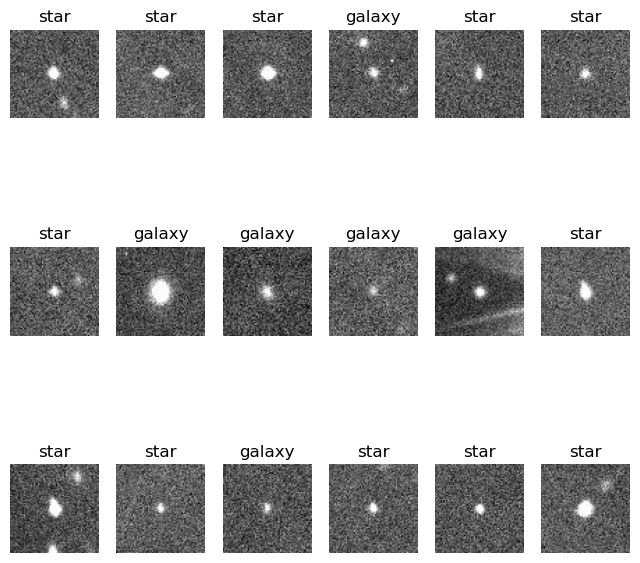

In [5]:
indices = np.random.choice(len(dataset.image), size=18)
plot_images(
    images=dataset.image[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
)

## Building the Model

We have decided to use a Convolutional Neural Network for our model. These are commonly used to analyze visual imagery. 

### Layers

Much like an onion or an ogre, a CNN model consists of layers.

The first few layers work with the input images more intuitively. The model takes in grayscale images, rescaling the `[0, 255]` values to `[0, 1]` (in both training and inference).

This function helps us create a new model to train with the same layers every time.

In [6]:
def create_model() -> tf.keras.Model:
    """Creates and compiles a CNN model."""
    
    model = models.Sequential(
        [
            # Input Layers
            layers.Input(shape=(64, 64, 1), name="input"),
            layers.Rescaling(scale=(1.0 / 255), name="rescale"),
            # Convolution Layers
            layers.Conv2D(
                filters=32, kernel_size=3, activation="relu", name="conv2d_1"
            ),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_2"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_1"),
            layers.Dropout(rate=0.25, name="dropout_1"),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_3"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_2"),
            layers.Dropout(rate=0.25, name="dropout_2"),
            layers.Conv2D(
                filters=128, kernel_size=3, activation="relu", name="conv2d_4"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_3"),
            layers.Dropout(rate=0.25, name="dropout_3"),
            # Deep Learning Layers
            layers.Flatten(name="flatten"),
            layers.Dense(
                units=1024,
                activation="relu",
                name="dense_1",
            ),
            layers.Dropout(rate=0.5, name="dropout_4"),
            # Output Layer
            layers.Dense(units=2, name="output"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

Let's instantiate a model.

In [7]:
model = create_model()

Keras provides us with a handy-dandy function to visualize our model. Let's see these layers.

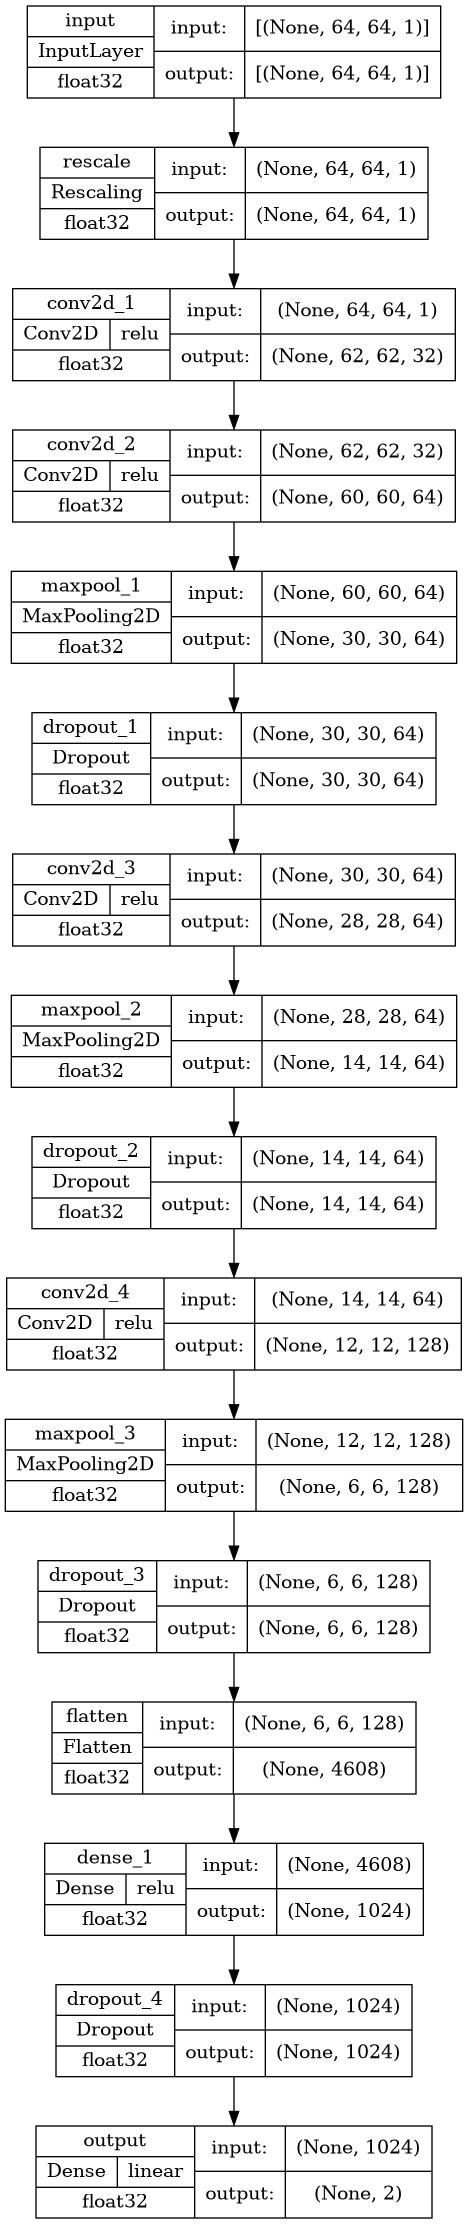

In [8]:
tf.keras.utils.plot_model(
    model=model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
)

## Training the Model

This is a helper function to both train and evaluate a model instance.

In [9]:
def train_test_model(model: tf.keras.Model, x, y, epochs: int = 30) -> tf.keras.callbacks.History:
    """Trains and evaluates a model."""
    
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Train model
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1,
    )

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.image, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        model.evaluate(_x, _y, verbose=2)

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
        print(f"galaxies ({n_galaxies})", end="\t")
        model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)

    return history

This is a helper function to display how the model performed with each epoch in training.

In [10]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    """Display the history of a model's training."""
    
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel("epoch")
    plt.show()

Let's train the model and see how it performs with relevant subsets of the dataset.

In [11]:
history = train_test_model(model=model, x=dataset.image, y=dataset.target)

Epoch 1/30
100/100 [==============================] - 18s 176ms/step - loss: 0.5771 - accuracy: 0.7607 - val_loss: 0.5573 - val_accuracy: 0.7569
Epoch 2/30
100/100 [==============================] - 16s 156ms/step - loss: 0.5487 - accuracy: 0.7638 - val_loss: 0.5243 - val_accuracy: 0.7569
Epoch 3/30
100/100 [==============================] - 16s 161ms/step - loss: 0.4634 - accuracy: 0.7676 - val_loss: 0.4204 - val_accuracy: 0.7995
Epoch 4/30
100/100 [==============================] - 16s 159ms/step - loss: 0.3686 - accuracy: 0.8312 - val_loss: 0.3911 - val_accuracy: 0.8421
Epoch 5/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3635 - accuracy: 0.8388 - val_loss: 0.3956 - val_accuracy: 0.8346
Epoch 6/30
100/100 [==============================] - 16s 160ms/step - loss: 0.3354 - accuracy: 0.8623 - val_loss: 0.3889 - val_accuracy: 0.8396
Epoch 7/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3331 - accuracy: 0.8588 - val_loss: 0.3495 - val_ac

## Evaluating the Model

Let's see how the model performed with each epoch.

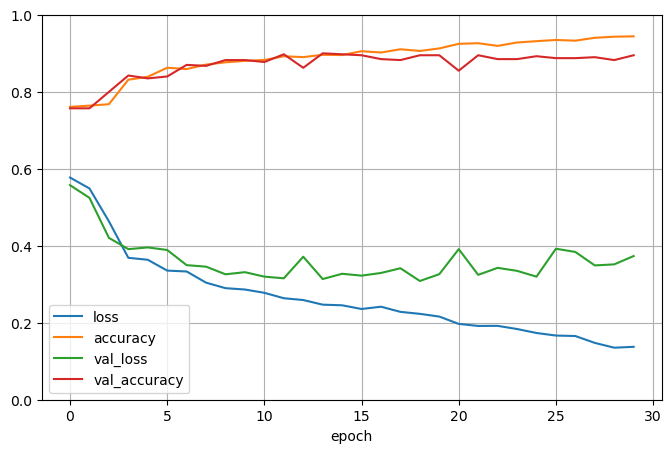

In [12]:
plot_history(history=history)

Let's see a random sample of images it is misclassifying.

Misclassified 154 images


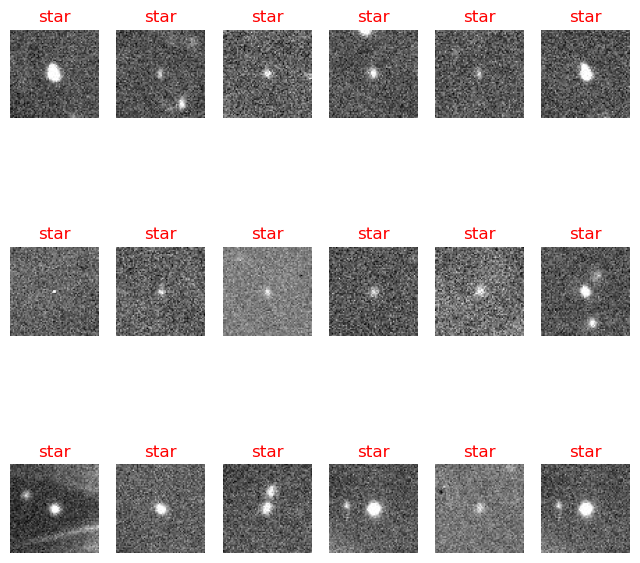

In [13]:
y_preds = np.argmax(model.predict(dataset.image, verbose=0), axis=1)
mispreds = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
    color="red",
)

To better visualize the error of the model, let's make what is called a "Confusion Matrix" or "Error Matrix". Here is a helper function to visualize a Confusion Matrix

In [14]:
def plot_conf_matrix(cm, labels):
    """Plots a confusion matrix with the given labels."""
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap("Blues")

    fig = plt.figure()
    axs = fig.add_subplot(111)

    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    thresh = np.max(cm) / 1.5

    caxs = axs.matshow(cm, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    fig.colorbar(caxs)

    plt.title("Confusion Matrix")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4}; misclass={misclass:0.4}")
    plt.ylabel("True label")

    ticklabels = np.concatenate(([""], labels))
    axs.set_xticklabels(ticklabels)
    axs.set_yticklabels(ticklabels)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i,j]:0.4}",
            ha="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.show()

Here is the confusion matrix for the model:

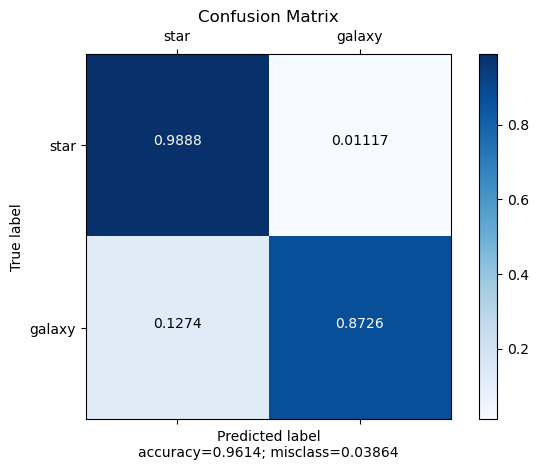

In [15]:
conf_matrix = tf.math.confusion_matrix(
    dataset.target,
    y_preds,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix, labels=dataset.target_names)

## Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

In [16]:
all_stars, all_galaxies = star_galaxy_split(dataset.image, dataset.target)
print(f"stars: {len(all_stars)} images")
print(f"galaxies: {len(all_galaxies)} images")

stars: 3044 images
galaxies: 942 images


## Attempt at a Solution

Our attempt at| solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing. Our function to load the dataset is able to do this for us, so let's create an "even" dataset.

In [17]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"'Even' dataset size: {len(dataset_even.image)} images")

'Even' dataset size: 1884 images


Now let's make a model and train it.

In [18]:
model_even = create_model()

history_even = train_test_model(
    model=model_even, x=dataset_even.image, y=dataset_even.target
)

Epoch 1/30
48/48 [==============================] - 8s 159ms/step - loss: 0.7033 - accuracy: 0.5103 - val_loss: 0.6930 - val_accuracy: 0.4894
Epoch 2/30
48/48 [==============================] - 7s 150ms/step - loss: 0.6638 - accuracy: 0.5899 - val_loss: 0.6395 - val_accuracy: 0.6064
Epoch 3/30
48/48 [==============================] - 7s 149ms/step - loss: 0.5287 - accuracy: 0.7538 - val_loss: 0.5047 - val_accuracy: 0.7553
Epoch 4/30
48/48 [==============================] - 7s 151ms/step - loss: 0.4674 - accuracy: 0.7910 - val_loss: 0.5123 - val_accuracy: 0.7447
Epoch 5/30
48/48 [==============================] - 7s 153ms/step - loss: 0.4431 - accuracy: 0.8089 - val_loss: 0.4768 - val_accuracy: 0.7766
Epoch 6/30
48/48 [==============================] - 8s 164ms/step - loss: 0.4283 - accuracy: 0.8162 - val_loss: 0.4525 - val_accuracy: 0.8085
Epoch 7/30
48/48 [==============================] - 7s 150ms/step - loss: 0.4126 - accuracy: 0.8182 - val_loss: 0.4142 - val_accuracy: 0.8351
Epoch 

Let's see the performance with each epoch.

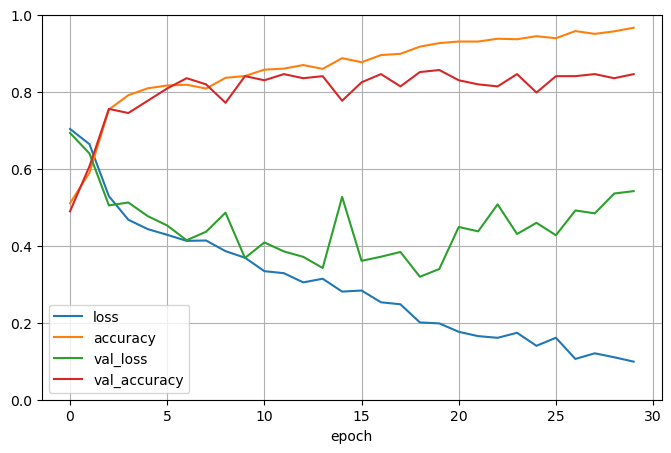

In [19]:
plot_history(history=history_even)

And now let's see a sample of the images it misclassified.

Misclassified 154 images


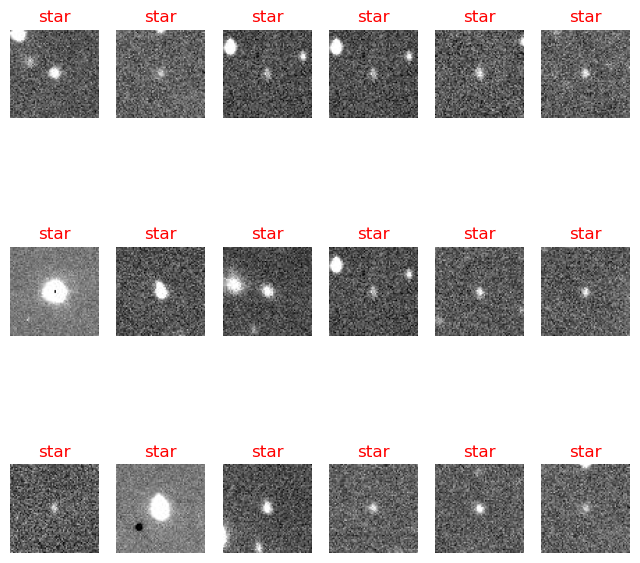

In [20]:
y_preds_even = np.argmax(model_even.predict(dataset.image, verbose=0), axis=1)
mispreds_even = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds_even)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
    color="red",
)

And a confusion matrix to more accurately visualize the errors.

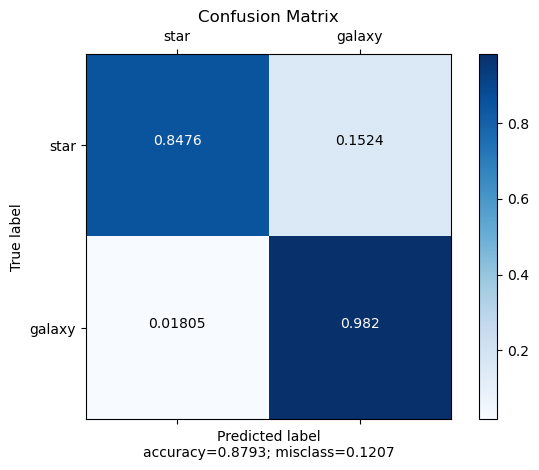

In [21]:
conf_matrix_even = tf.math.confusion_matrix(
    dataset.target,
    y_preds_even,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix_even, labels=dataset.target_names)

## Conclusions

TBD